# Models analysis notebook

This notebook presents a comparative analysis of several machine learning models for monthly deal prediction. Linear Regression, Random Forest, and XGBoost will be evaluated as the primary approaches. The main goal is to select the best-performing model based on MAPE and visualize the results, including feature importance and out-of-sample forecasting. All results are documented for transparency and reproducibility.


### Let's choose the model.

               Model       MAPE
0  Linear Regression  80.767817
1      Random Forest   7.911734
2            XGBoost   5.389688


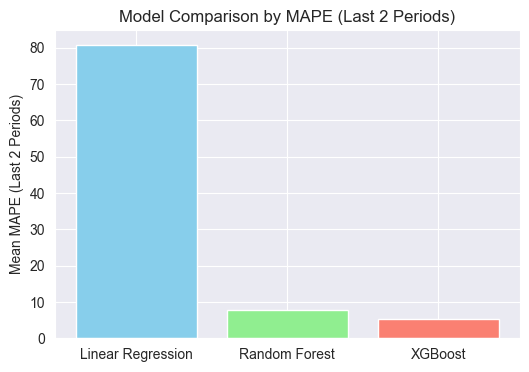

In [52]:
import sys
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(str(Path.cwd().parent))
from scripts.validate_model import validate_model
from src.rawdata import RawData
from src.features import Features

linreg_results = validate_model(model=LinearRegression(), data_path="../data/raw_data.csv", target="Deals")
rf_results = validate_model(model=RandomForestRegressor(random_state=42), data_path="../data/raw_data.csv", target="Deals")
xgb_results = validate_model(model=XGBRegressor(random_state=42), data_path="../data/raw_data.csv", target="Deals")

linreg_results['Model'] = 'Linear Regression'
rf_results['Model'] = 'Random Forest'
xgb_results['Model'] = 'XGBoost'

linreg_last2 = linreg_results.tail(2)
rf_last2 = rf_results.tail(2)
xgb_last2 = xgb_results.tail(2)

all_last2 = pd.concat([linreg_last2, rf_last2, xgb_last2], ignore_index=True)

mape_summary_last2 = all_last2.groupby('Model')['MAPE'].mean().reset_index()
print(mape_summary_last2)

plt.figure(figsize=(6,4))
plt.bar(mape_summary_last2['Model'], mape_summary_last2['MAPE'], color=['skyblue','lightgreen','salmon'])
plt.ylabel('Mean MAPE (Last 2 Periods)')
plt.title('Model Comparison by MAPE (Last 2 Periods)')
plt.show()

### Now we can check preictions in comparison with real deals.

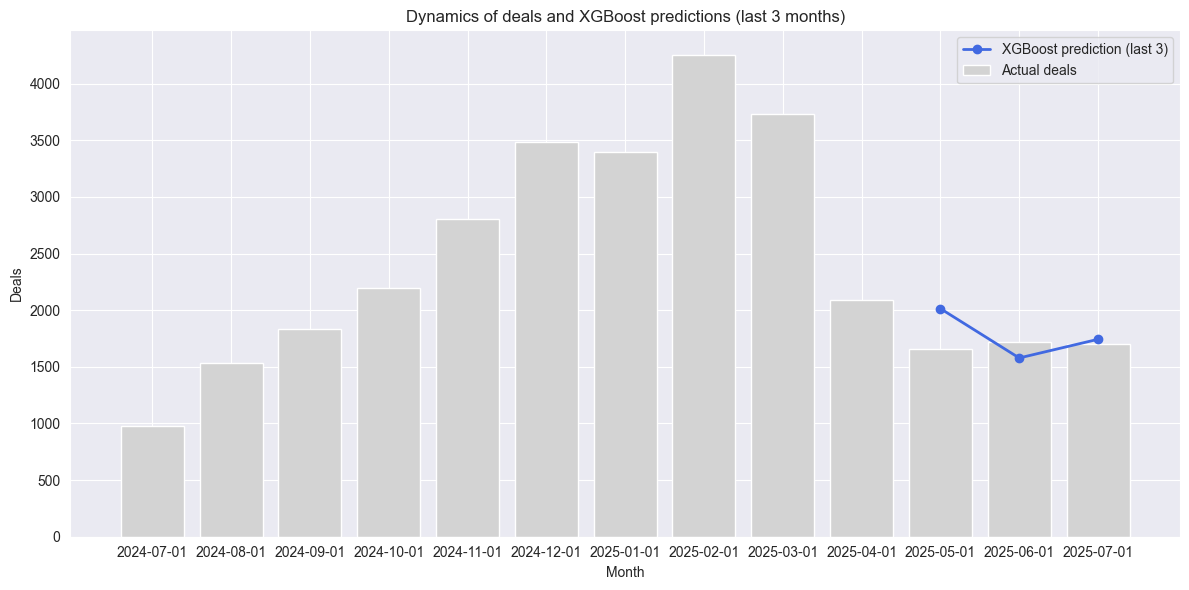

In [53]:
fact = RawData(file_path="../data/raw_data.csv").target("Deals")

last_months = fact['Month'].iloc[-3:]

xgb_results = validate_model(
    model=XGBRegressor(random_state=42),
    data_path="../data/raw_data.csv",
    target="Deals"
)

preds = xgb_results['Predicted'].values[-3:]

plt.figure(figsize=(12,6))
plt.bar(fact['Month'].astype(str), fact['Deals'], color='lightgrey', label='Actual deals')
plt.plot(last_months.astype(str), preds, color='royalblue', marker='o', linewidth=2, label='XGBoost prediction (last 3)')
plt.title("Dynamics of deals and XGBoost predictions (last 3 months)")
plt.xlabel("Month")
plt.ylabel("Deals")
plt.legend()
plt.tight_layout()
plt.show()


### But some features may be the most important. Let's find them.

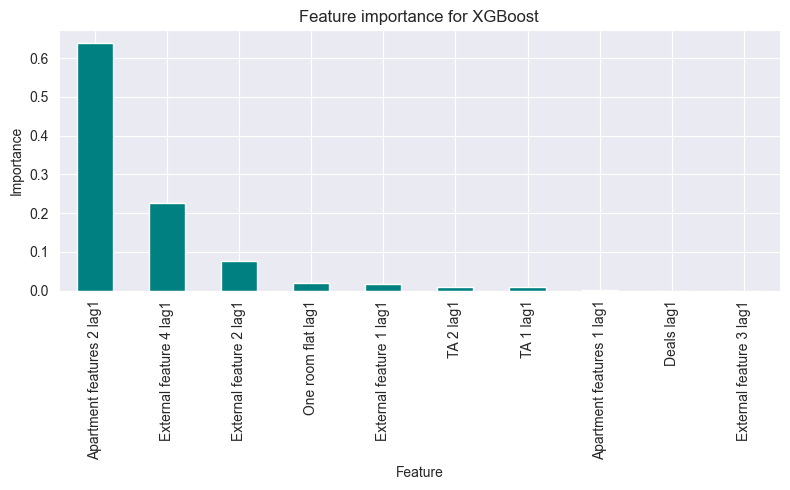

In [54]:
X = (
    Features(
        RawData("../data/raw_data.csv")
        .make_features()
    )
    .add_sin_seasonality(period=12)
    .add_cos_seasonality(period=12)
    .prepare_data()
)

X = X.drop(columns=['Month'], errors='ignore')
feature_names = X.columns

y = RawData("../data/raw_data.csv").target("Deals")
y = y.drop(columns=['Month'], errors='ignore')

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X, y)

importances = pd.Series(xgb_model.feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importances.head(10).plot(kind='bar', color='teal')
plt.title('Feature importance for XGBoost')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

### I want to compare two models: first model with all features and second - with top 8 features.

MAPE полная модель: 0.00%
MAPE только топ-фичи: 0.00%


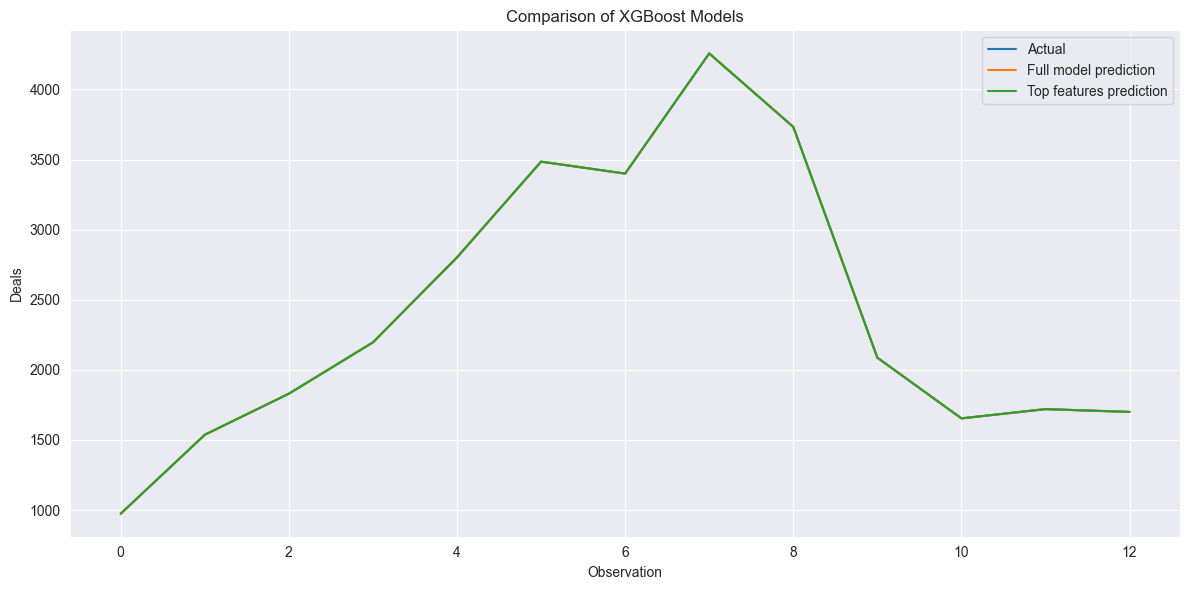

In [56]:
from sklearn.metrics import mean_absolute_percentage_error

X_full = (
    Features(
        RawData("../data/raw_data.csv")
        .make_features()
    )
    .add_sin_seasonality(period=12)
    .add_cos_seasonality(period=12)
    .prepare_data()
).drop(columns=['Month'], errors='ignore')

y = RawData("../data/raw_data.csv").target("Deals").drop(columns=['Month'], errors='ignore')

top_features = [
    "Apartment features 2 lag1",
    "Apartment features 1 lag1",
    "External feature 4 lag1",
    "External feature 2 lag1",
    "One room flat lag1",
    "External feature 1 lag1",
    "TA 2 lag1",
    "TA 1 lag1"
]

X_top = X_full[top_features]

xgb_full = XGBRegressor(random_state=42)
xgb_full.fit(X_full, y)
y_pred_full = xgb_full.predict(X_full)

xgb_top = XGBRegressor(random_state=42)
xgb_top.fit(X_top, y)
y_pred_top = xgb_top.predict(X_top)

mape_full = mean_absolute_percentage_error(y, y_pred_full) * 100
mape_top = mean_absolute_percentage_error(y, y_pred_top) * 100

print(f"MAPE полная модель: {mape_full:.2f}%")
print(f"MAPE только топ-фичи: {mape_top:.2f}%")

plt.figure(figsize=(12,6))
plt.plot(y.values, label="Actual")
plt.plot(y_pred_full, label="Full model prediction")
plt.plot(y_pred_top, label="Top features prediction")
plt.title("Comparison of XGBoost Models")
plt.ylabel("Deals")
plt.xlabel("Observation")
plt.legend()
plt.tight_layout()
plt.show()